## MODELOS DE Feed Forward NN PARA DEMANDA DE GAS NATURAL EN SECTOR ELÉCTRICO EN MÉXICO


Importamos la data de Demanda de gas en sector eléctrico como un CSV

In [115]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [116]:
csv_demanda_electrico_original = pd.read_csv('Demanda_electrico_2022_full1.csv',index_col='Date',parse_dates=True)
csv_demanda_electrico_original

,Demanded_Gas
Date,
2005-01-01,1819.58
2005-02-01,1895.33
2005-03-01,1765.86
2005-04-01,1642.70
2005-05-01,1895.54
...,...
2022-05-01,3350.03
2022-06-01,3498.70
2022-07-01,3350.97


Vamos a graficar los datos "originales" de demanda eléctrico desde 2005 hasta 2022

Text(0, 0.5, 'Demanda [MMpcd]')

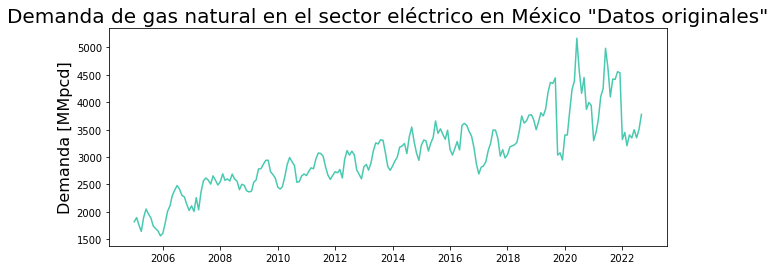

In [117]:
plt.figure(figsize=(10,4))
plt.plot(csv_demanda_electrico_original, color='#48C9B0')
plt.title('Demanda de gas natural en el sector eléctrico en México "Datos originales"', fontsize=20)
plt.ylabel('Demanda [MMpcd]', fontsize =16)

Vamos a descomponer la serie de tiempo de datos "originales" de demanda eléctrico desde 2005 hasta 2022 en sus compoentes de Tendencia, Estacionalidad y Residual 

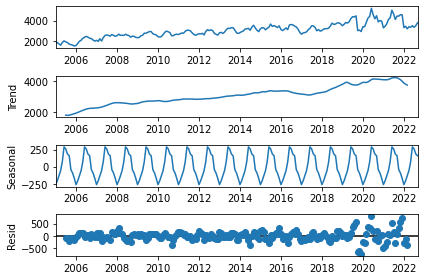

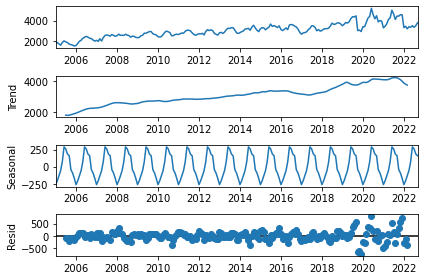

In [118]:
from statsmodels.tsa.seasonal import seasonal_decompose

csv_demanda_electrico_original_seasonal_decomposition = seasonal_decompose(csv_demanda_electrico_original)
csv_demanda_electrico_original_seasonal_decomposition.plot()

In [119]:
import numpy as np
import tensorflow as tf

# Set a seed for numpy random number generation
np.random.seed(0)

# Set a seed for TensorFlow random number generation
tf.random.set_seed(0)

Proceso de Pretratamiento (Ajuste de vaores atípicos por media aritmetica de serie) como una estrategia para mejorar los resultados de forecast de modelos Feed Forward Neural Networks

In [120]:
outlier_threshold = 1.2

import pandas as pd

def remove_replace_outliers(data):
    # Calculate Q1 and Q3
    Q1 = data.quantile(0.25)
    Q3 = data.quantile(0.75)
    IQR = Q3 - Q1

    # Identify outliers
    outliers_mask = (data < (Q1 - outlier_threshold * IQR)) | (data > (Q3 + outlier_threshold * IQR))

    # Calculate the historical mean excluding outliers
    historical_mean = data[~outliers_mask].mean()

    # Replace outliers with historical mean
    data.loc[outliers_mask] = historical_mean

    return data

In [121]:
csv_demanda_electrico_pretratamiento1 = remove_replace_outliers(csv_demanda_electrico_original['Demanded_Gas'])
csv_demanda_electrico_pretratamiento1

Date
2005-01-01    1819.58
2005-02-01    1895.33
2005-03-01    1765.86
2005-04-01    1642.70
2005-05-01    1895.54
               ...   
2022-05-01    3350.03
2022-06-01    3498.70
2022-07-01    3350.97
2022-08-01    3506.42
2022-09-01    3778.37
Name: Demanded_Gas, Length: 213, dtype: float64

Separamos la Demanda de gas natural en el sector eléctrico en data de train y test

In [122]:
# Number of data points to keep for testing (in this case, the last 12)
num_test_points = 12

# Split the data into training and testing sets
csv_demanda_electrico_pretratamiento1_train_data = csv_demanda_electrico_pretratamiento1[:-num_test_points]
csv_demanda_electrico_pretratamiento1_test_data = csv_demanda_electrico_pretratamiento1[-num_test_points:]

csv_demanda_electrico_pretratamiento1_train_data

Date
2005-01-01    1819.5800
2005-02-01    1895.3300
2005-03-01    1765.8600
2005-04-01    1642.7000
2005-05-01    1895.5400
                ...    
2021-05-01    4243.9300
2021-06-01    2967.1562
2021-07-01    2967.1562
2021-08-01    4098.8100
2021-09-01    2967.1562
Name: Demanded_Gas, Length: 201, dtype: float64

Se generan sets de n_input datos para con ellos predecir el t+1 dato, y así los siguientes n_input para predecir el t+1, etc 

In [123]:
from keras.preprocessing.sequence import TimeseriesGenerator

Se aplica el TimeseriesGnerator para producir sets de n_inputs + 1 output para el caso de

In [124]:
n_input = 48

data = csv_demanda_electrico_pretratamiento1_train_data
targets = data 

demanda_electrico_pretratamiento1_train_generator = TimeseriesGenerator(data, targets, length=n_input, batch_size=1)


In [125]:
demanda_electrico_pretratamiento1_train_generator[0]

(array([[1819.58  , 1895.33  , 1765.86  , 1642.7   , 1895.54  , 2051.72  ,
         1962.05  , 1889.66  , 1739.1   , 1695.92  , 1648.95  , 2967.1562,
         2967.1562, 1806.33  , 2006.88  , 2108.31  , 2298.9   , 2398.88  ,
         2480.62  , 2413.08  , 2298.49  , 2273.91  , 2134.41  , 2025.98  ,
         2108.85  , 2006.81  , 2259.02  , 2036.62  , 2361.78  , 2567.22  ,
         2618.43  , 2579.35  , 2506.83  , 2657.24  , 2577.97  , 2489.39  ,
         2548.33  , 2694.39  , 2575.71  , 2600.26  , 2562.91  , 2689.6   ,
         2598.57  , 2561.87  , 2404.84  , 2503.78  , 2482.93  , 2383.92  ]]),
 array([2364.05]))

Y entonces el numero de muestras formadas con el TimeseriesGenerator = Numero de elementos de array original - n_input

In [126]:
print("Total number of samples in the original training data = ", len(csv_demanda_electrico_pretratamiento1_train_data)) 
print("Total number of samples in the demanda_electrico_scaled_train_generator = ", len(demanda_electrico_pretratamiento1_train_generator))

Total number of samples in the original training data =  201
Total number of samples in the demanda_electrico_scaled_train_generator =  153


Se importan las librerias necesarias para definir la red Neuronal de tipo Feed Forward Sequential Neural Network

In [127]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

Se define la red neuronal sequencial FFNN con capas densas y funcion de activación tipo RELU. 

La primer cada Dense constará de N, nodos y n_input inputs.
Por lo que el número de parámetros a estimar para esta primer capa sería 
Parámetros_n_capa_densa = n_input *  #Nodos + # Nodos
Donde  n_input *  #Nodos: Representa la matriz de pesos 
Y # Nodos: el vector de bias  


In [128]:
n_input = 48
n_features = 1

# define model
model_sequential_and_FF = Sequential()
model_sequential_and_FF.add(Dense(64, activation='relu', input_shape=(n_input, n_features)))
model_sequential_and_FF.add(Dense(32, activation='relu'))
model_sequential_and_FF.add(Dense(1))
model_sequential_and_FF.compile(optimizer='Adam', loss='mse')

In [129]:
model_sequential_and_FF.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_12 (Dense)            (None, 48, 64)            128       
                                                                 
 dense_13 (Dense)            (None, 48, 32)            2080      
                                                                 
 dense_14 (Dense)            (None, 48, 1)             33        
                                                                 
Total params: 2241 (8.75 KB)
Trainable params: 2241 (8.75 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


Entrenamos el modelo  Feed Forward Sequential Neural Network con el demanda_electrico_scaled_train_generator.
Es decir se está entrenando al modelo para que con los valores de entrenamiento "ajuste sus pesos y bias" de manera que se esté tomando n_inputs como "variables predictoas" y el +1 valor después de los n_input como variable dependiente Y. y asñi se va recorriendo el n_input. De manera que se tienen n_total_elementos_en_train - n_input valores de entrada de tamaño n_input y n_total_elementos_en_train - n_input valores de salida de tamaño 1 (Representando la Y calculada)  

In [130]:
model_sequential_and_FF.fit(demanda_electrico_pretratamiento1_train_generator, epochs=25)

Epoch 1/25


153/153 [==============================] - 1s 2ms/step - loss: 1908735.7500
Epoch 2/25
153/153 [==============================] - 0s 2ms/step - loss: 189791.6094
Epoch 3/25
153/153 [==============================] - 0s 2ms/step - loss: 192684.9219
Epoch 4/25
153/153 [==============================] - 0s 3ms/step - loss: 198743.1250
Epoch 5/25
153/153 [==============================] - 0s 2ms/step - loss: 193295.4844
Epoch 6/25
153/153 [==============================] - 0s 2ms/step - loss: 194122.5469
Epoch 7/25
153/153 [==============================] - 0s 2ms/step - loss: 199117.8125
Epoch 8/25
153/153 [==============================] - 0s 2ms/step - loss: 197829.9688
Epoch 9/25
153/153 [==============================] - 0s 3ms/step - loss: 193555.2969
Epoch 10/25
153/153 [==============================] - 0s 3ms/step - loss: 188675.5156
Epoch 11/25
153/153 [==============================] - 0s 2ms/step - loss: 191386.5781
Epoch 12/25
153/153 [==============================] - 0s 2ms/

Se grafica la perdida por epoch 

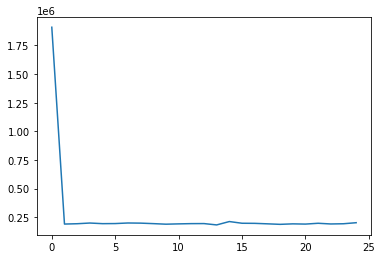

In [131]:
loss_per_epoch = model_sequential_and_FF.history.history['loss']
plt.plot(range(len(loss_per_epoch)),loss_per_epoch)

Se lleva a cabo el forecast de los ultimos 12 meses usando el modelo model_sequential_and_FF previamente definido y entrenado

Se toman los **ULTIMOS** n_input elementos de los **datos de train** y se almacenan en un batch

In [132]:
demanda_electrico_pretratamiento1_train_batch = csv_demanda_electrico_pretratamiento1_train_data.values[-n_input:]


demanda_electrico_pretratamiento1_train_batch

array([3017.18  , 3135.4   , 2983.61  , 3041.46  , 3186.84  , 3203.37  ,
       3222.52  , 3270.33  , 3479.69  , 3751.09  , 3620.71  , 3664.34  ,
       3765.69  , 3772.25  , 3676.41  , 3500.08  , 3647.6   , 3807.71  ,
       3750.5   , 3876.48  , 4184.76  , 4361.97  , 4343.61  , 2967.1562,
       3037.44  , 3076.62  , 2947.09  , 3402.47  , 3402.47  , 3819.3   ,
       4235.25  , 2967.1562, 2967.1562, 2967.1562, 4163.77  , 2967.1562,
       3869.77  , 3996.14  , 3941.12  , 3298.43  , 3454.21  , 3681.3   ,
       4104.82  , 4243.93  , 2967.1562, 2967.1562, 4098.81  , 2967.1562])

Se reescala el batch de los datos de train a que tenga la misma forma que los datos con que se entrenó el modelo que fueron  1, input_shape=(n_input, n_features)

In [133]:
demanda_electrico_pretratamiento1_train_batch_reshaped = demanda_electrico_pretratamiento1_train_batch.reshape(1,n_input, n_features)
demanda_electrico_pretratamiento1_train_batch_reshaped

array([[[3017.18  ],
        [3135.4   ],
        [2983.61  ],
        [3041.46  ],
        [3186.84  ],
        [3203.37  ],
        [3222.52  ],
        [3270.33  ],
        [3479.69  ],
        [3751.09  ],
        [3620.71  ],
        [3664.34  ],
        [3765.69  ],
        [3772.25  ],
        [3676.41  ],
        [3500.08  ],
        [3647.6   ],
        [3807.71  ],
        [3750.5   ],
        [3876.48  ],
        [4184.76  ],
        [4361.97  ],
        [4343.61  ],
        [2967.1562],
        [3037.44  ],
        [3076.62  ],
        [2947.09  ],
        [3402.47  ],
        [3402.47  ],
        [3819.3   ],
        [4235.25  ],
        [2967.1562],
        [2967.1562],
        [2967.1562],
        [4163.77  ],
        [2967.1562],
        [3869.77  ],
        [3996.14  ],
        [3941.12  ],
        [3298.43  ],
        [3454.21  ],
        [3681.3   ],
        [4104.82  ],
        [4243.93  ],
        [2967.1562],
        [2967.1562],
        [4098.81  ],
        [2967

Intentamos predecir el sigueinte valor dado el primet batch de n_input. Esto equivaldria a predecir el primer valor de los datos de test (PUES SE ESTÁN TOMANDO EXACTAMENTE LOS ULTIMOS VALORES DE LOS DATOS DE TRAIN EN EL BATCH), dados los n_input anteriores (QUE FORMAN BARTE DEL BATCH)

In [134]:
model_sequential_and_FF.predict(demanda_electrico_pretratamiento1_train_batch_reshaped)

1/1 [==============================] - 0s 193ms/step


array([[[3043.992 ],
        [3163.135 ],
        [3010.1602],
        [3068.4617],
        [3214.9773],
        [3231.6365],
        [3250.9358],
        [3299.1191],
        [3510.1143],
        [3783.6345],
        [3652.2358],
        [3696.207 ],
        [3798.3481],
        [3804.9595],
        [3708.3704],
        [3530.6638],
        [3679.3357],
        [3840.6963],
        [3783.0398],
        [3910.0037],
        [4220.691 ],
        [4399.285 ],
        [4380.7817],
        [2993.578 ],
        [3064.4104],
        [3103.8965],
        [2973.3547],
        [3432.2913],
        [3432.2913],
        [3852.3767],
        [4271.575 ],
        [2993.578 ],
        [2993.578 ],
        [2993.578 ],
        [4199.5366],
        [2993.578 ],
        [3903.2412],
        [4030.598 ],
        [3975.1487],
        [3327.4387],
        [3484.4358],
        [3713.299 ],
        [4140.1265],
        [4280.323 ],
        [2993.578 ],
        [2993.578 ],
        [4134.0693],
        [2993

Y se observa el valor predicho ESCALADO para la demanda de gas en el primer mes o dato de prueba como función de los n datos anteriores y dado el modelo model_sequential_and_FF

In [135]:
model_sequential_and_FF.predict(demanda_electrico_pretratamiento1_train_batch_reshaped)[0][-1][0]

1/1 [==============================] - 0s 25ms/step


2993.578

Ahora ser hará una función que irá formando batch de n_input para ir prediciendo el siguiente valor, tal como se hizo en el entrenamiento del modelo

In [136]:
n_input = 48
n_features = 1

In [137]:
test_predictions_model_sequential_and_FF = []

first_eval_batch = csv_demanda_electrico_pretratamiento1_train_data.values[-n_input:]
current_batch = first_eval_batch.reshape((1, n_input, n_features))

for i in range(len(csv_demanda_electrico_pretratamiento1_test_data)):
    
    # get the prediction value for the first batch
    current_pred = model_sequential_and_FF.predict(current_batch)[0][-1][0]
    
    # append the prediction into the array
    test_predictions_model_sequential_and_FF.append(current_pred) 
    
    # use the prediction to update the batch and remove the first value
    current_batch = np.append(current_batch[:,1:,:],[[[current_pred]]],axis=1)
    current_batch = current_batch.reshape((1, n_input, n_features))  # Reshape to maintain 

1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - 0s 21ms/step


In [138]:
test_predictions_model_sequential_and_FF

[2993.578,
 3020.2056,
 3047.0417,
 3074.0872,
 3101.3438,
 3128.8135,
 3156.4973,
 3184.3972,
 3212.5154,
 3240.8533,
 3269.4124,
 3298.1946]

In [139]:
import numpy as np

# Convert the Python list to a NumPy array
test_predictions_model_sequential_and_FF_array = np.array(test_predictions_model_sequential_and_FF)

# Assuming test_predictions is your 1D array
# Reshape it into a 2D array with a single column
test_predictions_model_sequential_and_FF_2d = test_predictions_model_sequential_and_FF_array.reshape(-1, 1)

test_predictions_model_sequential_and_FF_2d

array([[2993.578 ],
       [3020.2056],
       [3047.0417],
       [3074.0872],
       [3101.3438],
       [3128.8135],
       [3156.4973],
       [3184.3972],
       [3212.5154],
       [3240.8533],
       [3269.4124],
       [3298.1946]], dtype=float32)

In [140]:
test_predictions_model_sequential_and_FF_2d

array([[2993.578 ],
       [3020.2056],
       [3047.0417],
       [3074.0872],
       [3101.3438],
       [3128.8135],
       [3156.4973],
       [3184.3972],
       [3212.5154],
       [3240.8533],
       [3269.4124],
       [3298.1946]], dtype=float32)

Separamos la Demanda de gas natural ORIGINAL en el sector eléctrico en data de train y test

In [141]:
# Number of data points to keep for testing (in this case, the last 12)
num_test_points = 12

# Split the data into training and testing sets
csv_demanda_electrico_original_train_data = csv_demanda_electrico_original[:-num_test_points]
csv_demanda_electrico_original_test_data = csv_demanda_electrico_original[-num_test_points:]

csv_demanda_electrico_original_train_data

,Demanded_Gas
Date,
2005-01-01,1819.5800
2005-02-01,1895.3300
2005-03-01,1765.8600
2005-04-01,1642.7000
2005-05-01,1895.5400
...,...
2021-05-01,4243.9300
2021-06-01,2967.1562
2021-07-01,2967.1562


In [112]:
csv_demanda_electrico_original_test_data['Demanded_Gas'].values

array([2967.1562, 2967.1562, 2967.1562, 3320.75  , 3449.8   , 3206.96  ,
       3403.44  , 3350.03  , 3498.7   , 3350.97  , 3506.42  , 3778.37  ])

Text(0, 0.5, 'Demanda [MMpcd]')

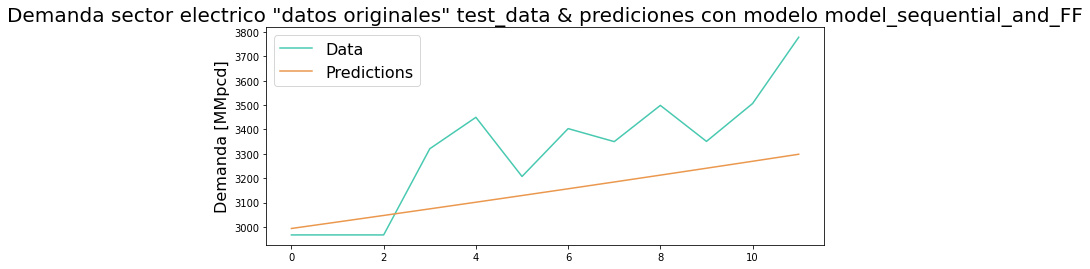

In [142]:
##Ploting the predicitons vs the test_data
plt.figure(figsize =(10,4))
plt.plot(csv_demanda_electrico_original_test_data['Demanded_Gas'].values, color='#48C9B0')
plt.plot(test_predictions_model_sequential_and_FF , color='#EB984E')
plt.legend(('Data', 'Predictions'), fontsize=16)

plt.title('Demanda sector electrico "datos originales" test_data & prediciones con modelo model_sequential_and_FF', fontsize=20)
plt.ylabel('Demanda [MMpcd]', fontsize=16)

In [143]:
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error
import numpy as np

# Compute errors
MAPE_predictions_model_sequential_and_FF = mean_absolute_percentage_error(csv_demanda_electrico_original_test_data['Demanded_Gas'].values, test_predictions_model_sequential_and_FF )
RMSE_predictions_model_sequential_and_FF = np.sqrt(mean_squared_error(csv_demanda_electrico_original_test_data['Demanded_Gas'].values, test_predictions_model_sequential_and_FF ))

print('MAPE:', MAPE_predictions_model_sequential_and_FF)
print('RMSE:', RMSE_predictions_model_sequential_and_FF)

MAPE: 0.05705807626708609
RMSE: 235.84043571742268
